In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import math

import datetime
import pandas as pd
import seaborn as sns
import tensorflow as tf

from ml.opt_weights import *
from ml.model_inputs import *
from ml.constructions import *
from ml.tests.gen_data import *
from ml.model import *
import ml.utils as ut

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


notes:
- use this: 
https://tensorflow.googlesource.com/tensorflow/+/master/tensorflow/models/image/mnist/convolutional.py
- incorporate cash in target
- output model weights
- make sure dropout it isn't applied to non train predictions
- get tensorboard working correctly
- add tensorboard saver to reinstantiate model
https://www.tensorflow.org/versions/r0.7/tutorials/mnist/tf/index.html#evaluate-the-model

add rolling model fit function

In [3]:
# import pandas.io.data as web
# start_date = datetime.date(2005,1,1)
# end_date = datetime.date(2012,5,1)
# #tickers = ["^GSPC", "^DJI", "^IXIC", "^FCHI", "^FTSE", "^N225"]
# tickers = ['GOOG', 'JPM', 'XOM', 'DIS', 'PFE', 'WMT']
# px = web.DataReader(tickers, 'yahoo', start_date, end_date).Close
# ret = px.div(px.shift()).dropna()
ret = pd.read_csv('tests/test_data/returns.csv', parse_dates=['Date'], index_col=0).applymap(lambda x: x - 1.)

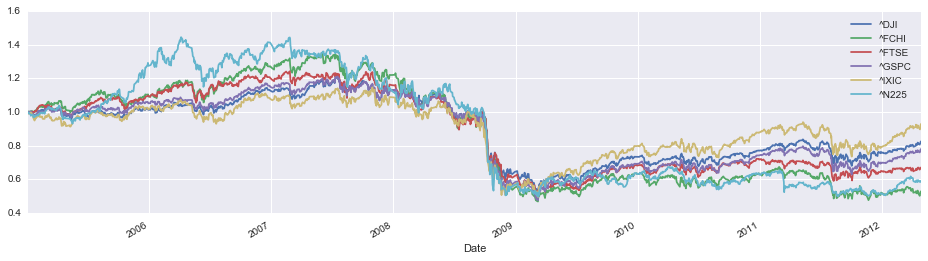

In [4]:
ret.applymap(lambda x: x + 1.).cumprod().plot(figsize=[16,4])

find optimal target regression parameters

In [5]:
# grid = opt_weight_ir_grid(ret, np.exp(np.linspace(-3, 5, 8)), look_ahead_pers=range(5,100,20))
# grid.to_csv('data/opt_weight_ir_grid_demo.csv', index=None)

In [6]:
grid = pd.read_csv('data/opt_weight_ir_grid.csv')
grid[grid.norm_type==2].pivot(index='alpha', columns='look_ahead_per', values='ir')

look_ahead_per,5,25,45,65,85
alpha,,,,,
0.049787,3.312739,2.111259,1.932982,1.586422,1.149195
0.156118,1.699949,1.618007,1.447178,1.239004,0.990086
0.489542,0.503850,0.539553,0.498404,0.471778,0.409084
1.535063,0.049903,0.065322,0.029271,-0.008264,-0.020794
4.813520,-0.091933,-0.083242,-0.121208,-0.157772,-0.154760
15.093825,-0.137179,-0.130933,-0.169443,-0.205618,-0.197299
47.329930,-0.151623,-0.146187,-0.184875,-0.220890,-0.210939
148.413159,-0.156231,-0.151057,-0.189803,-0.225756,-0.215300


prep model inputs

In [8]:
opt_weights_func = lambda x: calc_opt_weights(x, alpha=.01, norm_type=2)
opt_weights = rolling_fit_opt_weights(ret, opt_weights_func, 25)
ys = pd.DataFrame(opt_weights.values, index=opt_weights.index, columns=opt_weights.columns)

In [13]:
peak = get_peak_ahead_returns(ret, 20)
rands = gen_random_normal(ys.index, 10)
f = lambda x: flatten_df(get_multi_freq_historical_returns(x, 2))
rec_ret2_flat = map_to_date(ret, '2007-1-1', f)
f = lambda x: get_multi_freq_historical_returns(x, 2)
rec_ret2 = map_to_date(ret, '2007-1-1', f)
cov = map_to_date(ret, '2007-1-1', get_flat_cov_matrix)
mom = get_momentum(ret, 6*30)
val = get_value(ret, 6*30)
#mom, val = map(lambda x: xs_score(x), [mom, val])

constructions.py:73: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  weekly = returns_vectors(cum_rets.resample('W', how='last'), per)
constructions.py:74: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  monthly = returns_vectors(cum_rets.resample('M', how='last'), per)
constructions.py:75: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  quarterly = returns_vectors(cum_rets.resample('Q', how='last'), per)
constructions.py:40: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(halflife=180,ignore_na=False,min_periods=90.0,adjust=True).mean()
  mean = pd.ewma(momentum, halflife=halflife, min_periods=float(halflife)/2)
constructions.py:41: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(halflife=180,ignore_na=False,mi

In [14]:
#Xs = pd.concat([rands], axis=1).dropna()
#Xs = pd.concat([rec_ret2_flat, cov, mom, val], axis=1).dropna()
#Xs = pd.concat([ys, cov, mom, val], axis=1).dropna()
Xs = pd.concat([peak, cov, mom, val], axis=1).dropna()
#Xs = create_2d_features(ret.index,  [rec_ret2, mom, val])

In [15]:
print Xs.shape, ys.shape
Xs, ys = validate_and_format_Xs_ys(Xs, ys)
train, test = split_inputs_by_date(Xs, ys, datetime.date(2200,1,1), buffer_periods=0)
Xs_train, ys_train = train[0].values, train[1].values 
print Xs_train.shape, ys_train.shape

(1323, 39) (1814, 6)
(1312, 39) (1312, 6)


In [27]:
dti = pd.DatetimeIndex(start='2000-1-1', freq='B', periods=500)
Xs, ys, _ = gen_2d_random_Xs_onehot_ys_from_random_kernel(dti, num_classes=15, num_features=10, noise_sigma=10.)
train_inps, test_inps = split_inputs_by_date(Xs, ys, datetime.date(2001,1,1), buffer_periods=0)
Xs_train, ys_train = train_inps
Xs_test, ys_test = test_inps
Xs_train_f = flatten_panel(Xs_train).values.astype(np.float32)
Xs_test_f = flatten_panel(Xs_test).values.astype(np.float32)
Xs_train = Xs_train.astype(np.float32).values
Xs_test = Xs_test.astype(np.float32).values
ys_train = ys_train
ys_test = ys_test
check_kernel_predictive_accuracy(Xs, ys, _)

0.374

n hidden layers with softmax

In [59]:
from model import *
log_path = '/Users/ryanchouck/dev/tf/data/tensor_board'
clear_path(log_path)
structure = [[],[3]]
preds, stats = train_nn_softmax([Xs_train_f, Xs_test_f], [ys_train.values, ys_test.values], 
                                structure, 1000, 500, .5, penalty_alpha=0., dropout_rate=0., logdir=log_path)

step     0:	train loss: 2.89	test loss: 2.76		(0.04 sec)
step   100:	train loss: 2.11	test loss: 2.78		(0.43 sec)
step   200:	train loss: 1.72	test loss: 2.98		(0.80 sec)
step   300:	train loss: 1.53	test loss: 3.22		(1.14 sec)
step   400:	train loss: 1.42	test loss: 3.45		(1.56 sec)
step   500:	train loss: 1.21	test loss: 3.67		(1.91 sec)
step   600:	train loss: 1.28	test loss: 3.87		(2.26 sec)
step   700:	train loss: 1.14	test loss: 4.05		(2.62 sec)
step   800:	train loss: 1.13	test loss: 4.20		(3.07 sec)
step   900:	train loss: 1.14	test loss: 4.34		(3.45 sec)
train accuracy:	0.72	test accuracy:	0.09
train loss:	1.08	test loss:	4.46


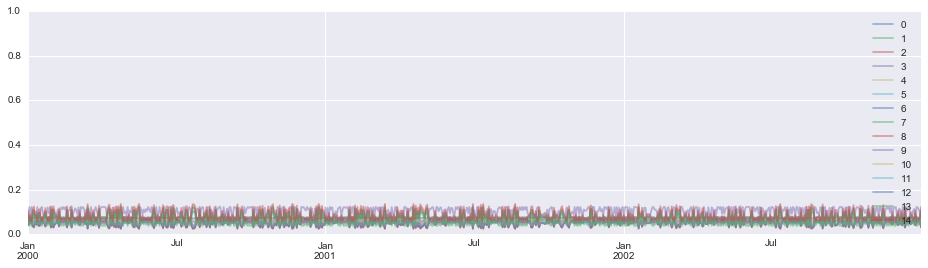

In [63]:
probs = pd.DataFrame(preds['train']['weights'], columns=ys_train.columns, index=ys_train.index)
probs.plot(figsize=[16,4], ylim=[0,1], alpha=.5)

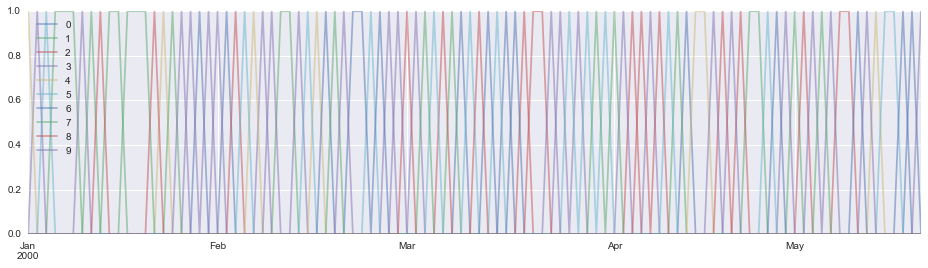

In [156]:
ys.plot(figsize=[16,4], ylim=[0,1], alpha=.5)

In [14]:
cols = list(ys.columns)
cols = dict(map(lambda x: (cols.index(x), x), cols))
labels = pd.Series(labels).map(lambda x: cols[x])
print('predicted max columns:')
print labels.value_counts()
print
print('actual max columns:')
print ys.apply(lambda x: list(x).index(max(x)), axis=1).map(lambda x: cols[x]).value_counts()

predicted max columns:
WMT     1073
PFE       96
DIS       95
GOOG      28
JPM       17
XOM        3
dtype: int64

actual max columns:
WMT     937
PFE     167
XOM      83
GOOG     82
DIS      34
JPM       9
dtype: int64


analytics

equal_weights   -0.147397
opt_weights      2.084345
dtype: float64

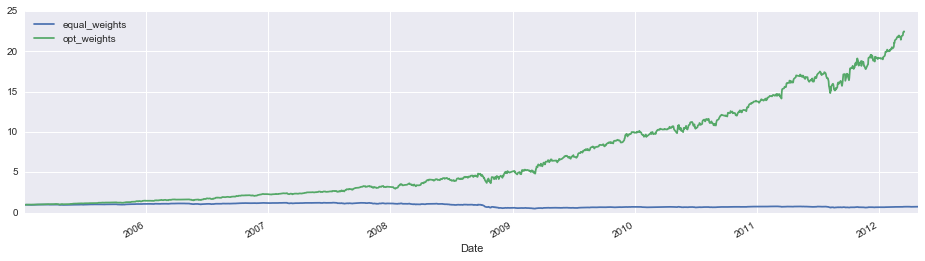

In [12]:
equal_weights = pd.Series({k: 1./ret.shape[1] for k in ret.columns})
perf = pd.DataFrame({'equal_weights': ret.mul(equal_weights).sum(axis=1),
                     'opt_weights': ret.mul(opt_weights).sum(axis=1),
                     #'model_weights': ret.mul(probs).sum(axis=1)
                    })
perf.applymap(lambda x: x + 1).cumprod().plot(figsize=[16,4])
ut.get_ir(perf)